In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
#from sklearn.metrics import r2_score
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.animation as animation # animation
import imageio 

import fiona
import rasterio
import rasterio.transform
import rasterio.mask
from fiona import Feature, Geometry
from shapely.geometry import mapping, shape
import os

In [2]:
common_years = np.arange(2005, 2017, 1)

#Get information from the shapefile

shape_file = '/Users/francesco/Desktop/squares.shp.gpkg'

ids = []
boundaries = []

# Open and extract boundaries
with fiona.open(shape_file, "r") as shapefile:
    for feature in shapefile:
        ids.append(int(feature['id'])) #id is registered as a string in the geometry file
        polygon = shape(feature['geometry'])
        bounds = polygon.bounds
        boundaries.append(bounds)

# Create a DataFrame with the information retrieved from the previous block
df = pd.DataFrame({'boundaries': boundaries}, index=ids)

# Sort the dataset according to the index
df = df.sort_index()
pd.set_option('display.max_rows', None)

# Display the DataFrame
print(df)


                                          boundaries
1  (-1992484.4850636236, -693975.9218715788, -148...


In [3]:
#Load the masks
cnn_dataset_directory = '/Users/francesco/Desktop/machine_learning_calving_project/dataset_cnn/'

ice_mask = np.load(cnn_dataset_directory + 'ice_mask.npy', allow_pickle=True)
land_mask = np.load(cnn_dataset_directory + 'land_mask.npy', allow_pickle=True)
sea_mask = np.load(cnn_dataset_directory + 'sea_mask.npy', allow_pickle=True)
grounded_ice_mask = np.load(cnn_dataset_directory + 'grounded_ice_mask.npy', allow_pickle=True)
boarders_mask = np.load(cnn_dataset_directory + 'boarders.npy', allow_pickle=True)

ice_mask = pd.DataFrame(ice_mask, index=df.index, columns=common_years)
land_mask = pd.DataFrame(land_mask, index=df.index, columns=common_years)
sea_mask = pd.DataFrame(sea_mask, index=df.index, columns=common_years)
grounded_ice_mask = pd.DataFrame(grounded_ice_mask, index=df.index, columns=common_years)
boarders_mask = pd.DataFrame(boarders_mask, index=df.index, columns=common_years)


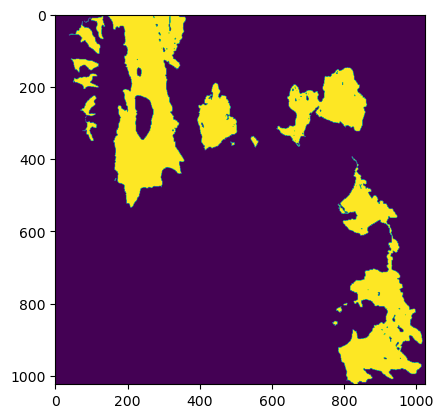

In [4]:
plt.imshow(ice_mask.loc[1,2015])

SIC dataset opening

In [5]:
#in this script i want to create a list of all the files i want to open

root = '/Users/francesco/Desktop/Thesis/Data/monthly/seaice_conc_monthly_sh_'

#################### first block ####################
start_date = "1978-11"
end_date = "1987-07"

date_range = pd.date_range(start=start_date, end=end_date, freq="MS")
date_list_1 = [date.strftime("%Y%m") for date in date_range]

end_1 = '_n07_v04r00.tif'
#################### second block ####################
start_date = "1987-08"
end_date = "1991-12"

date_range = pd.date_range(start=start_date, end=end_date, freq="MS")
date_list_2 = [date.strftime("%Y%m") for date in date_range]
end_2 = '_f08_v04r00.tif'
#################### third block ####################
start_date = "1992-01"
end_date = "1995-09"

date_range = pd.date_range(start=start_date, end=end_date, freq="MS")
date_list_3 = [date.strftime("%Y%m") for date in date_range]
end_3 = '_f11_v04r00.tif'
#################### fourth block ####################
start_date = "1995-10"
end_date = "2007-12"

date_range = pd.date_range(start=start_date, end=end_date, freq="MS")
date_list_4 = [date.strftime("%Y%m") for date in date_range]
end_4 = '_f13_v04r00.tif'
#################### fifth block ####################
start_date = "2008-01"
end_date = "2022-12"

date_range = pd.date_range(start=start_date, end=end_date, freq="MS")
date_list_5 = [date.strftime("%Y%m") for date in date_range]
end_5 = '_f17_v04r00.tif'
#####################################################

primo = []
for i in date_list_1:
    tmp = root + str(i) + end_1
    primo.append(tmp)

secondo = []
for i in date_list_2:
    tmp = root + str(i) + end_2
    secondo.append(tmp)

terzo = []
for i in date_list_3:
    tmp = root + str(i) + end_3
    terzo.append(tmp)

quarto = []
for i in date_list_4:
    tmp = root + str(i) + end_4
    quarto.append(tmp)

quinto = []
for i in date_list_5:
    tmp = root + str(i) + end_5
    quinto.append(tmp)

#now i want to merge the lists
#list_of_files = primo + secondo + terzo + quarto + quinto
list_of_files = terzo + quarto + quinto
list_of_files = list_of_files[156:300] #this way i am selecting from 2005 till 2016 (included)

In [6]:
print(np.shape(list_of_files))

(144,)


In [77]:
list_of_files[0]

'/Users/francesco/Desktop/Thesis/Data/monthly/seaice_conc_monthly_sh_200501_f13_v04r00.tif'

In [124]:
#Averaging all the years

sic = pd.DataFrame(index = df.index, columns = common_years)

for id in df.index:

    month = 0

    for year in common_years:

        image_avg = np.zeros((1024,1024))

        for i in range(0,12):

            j = month + i
            file = list_of_files[j]
            print(file)

            with rasterio.open(file, crs = 'EPSG:3031') as src:

                xmin, ymin, xmax, ymax = df.loc[id, 'boundaries']
                window = rasterio.windows.from_bounds(xmin, ymin, xmax, ymax, src.transform) 
                image = src.read(1, window=window) #this is bm in the window
                image_avg = image_avg + image
                
                if i == 11:
                    print('Saved till month ' + str(j))
                    image_avg = image_avg/12
                    sic.loc[id,year] = image_avg
                    month = month + 12


/Users/francesco/Desktop/Thesis/Data/monthly/seaice_conc_monthly_sh_200501_f13_v04r00.tif
/Users/francesco/Desktop/Thesis/Data/monthly/seaice_conc_monthly_sh_200502_f13_v04r00.tif
/Users/francesco/Desktop/Thesis/Data/monthly/seaice_conc_monthly_sh_200503_f13_v04r00.tif
/Users/francesco/Desktop/Thesis/Data/monthly/seaice_conc_monthly_sh_200504_f13_v04r00.tif
/Users/francesco/Desktop/Thesis/Data/monthly/seaice_conc_monthly_sh_200505_f13_v04r00.tif
/Users/francesco/Desktop/Thesis/Data/monthly/seaice_conc_monthly_sh_200506_f13_v04r00.tif
/Users/francesco/Desktop/Thesis/Data/monthly/seaice_conc_monthly_sh_200507_f13_v04r00.tif
/Users/francesco/Desktop/Thesis/Data/monthly/seaice_conc_monthly_sh_200508_f13_v04r00.tif
/Users/francesco/Desktop/Thesis/Data/monthly/seaice_conc_monthly_sh_200509_f13_v04r00.tif
/Users/francesco/Desktop/Thesis/Data/monthly/seaice_conc_monthly_sh_200510_f13_v04r00.tif
/Users/francesco/Desktop/Thesis/Data/monthly/seaice_conc_monthly_sh_200511_f13_v04r00.tif
/Users/fra

In [137]:
# Now I want to put the ice and land, and grounded masks on top of the sic

for id in df.index:
    
        for year in common_years:
    
            sic.loc[id,year] = np.where(sic.loc[id,year]==251, np.nan, sic.loc[id,year])
            sic.loc[id,year] = np.where(sic.loc[id,year]==252, np.nan, sic.loc[id,year])
            sic.loc[id,year] = np.where(sic.loc[id,year]==254, np.nan, sic.loc[id,year])
            sic.loc[id,year] = np.where(sic.loc[id,year]==255, np.nan, sic.loc[id,year])

            sic.loc[id,year] = np.where(~sea_mask.loc[id,year], np.nan, sic.loc[id,year])

Text(0.5, 1.0, 'Sea Ice Concentration for 2012')

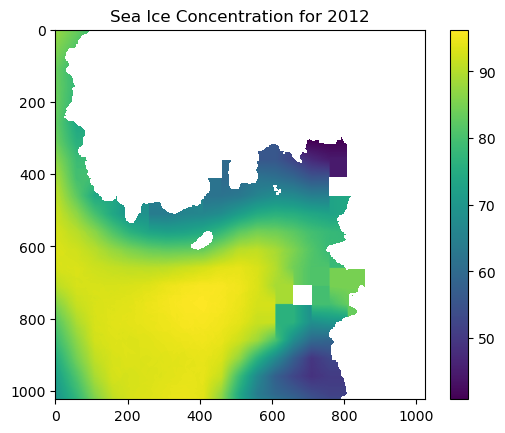

In [138]:
plt.imshow(sic.loc[1,2012])
plt.colorbar()
plt.title('Sea Ice Concentration for 2012')

In [139]:
#Now perform the interpolation
from skimage.restoration import inpaint

sic_interpolated = pd.DataFrame(index = df.index, columns = common_years)

for id in df.index:
    for year in common_years:

        print(id, year)

        sea_ice_tmp = sic.loc[id, year]
        nan_mask = np.isnan(sea_ice_tmp)
        sea_ice_tmp = inpaint.inpaint_biharmonic(sea_ice_tmp, nan_mask)
        sea_ice_tmp = np.where(~sea_mask.loc[id,year] , 0, sea_ice_tmp)

        sic_interpolated.loc[id, year] = sea_ice_tmp


1 2005
1 2006
1 2007
1 2008
1 2009
1 2010
1 2011
1 2012
1 2013
1 2014
1 2015
1 2016


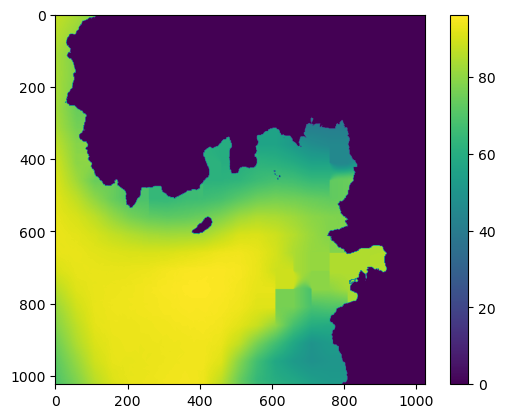

In [143]:
plt.imshow(sic_interpolated.loc[1,2012])
plt.colorbar()

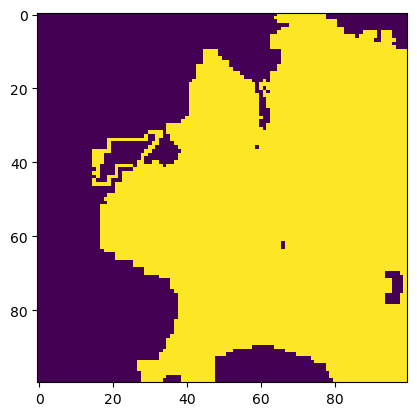

In [59]:
plt.imshow(ice_mask.loc[1,2012][700:800,800:900])

In [144]:
plot_images_to_pdf(sea_mask, common_years)

In [43]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.backends.backend_pdf import PdfPages

def plot_images_to_pdf(dataset, common_years, vmin = None, vmax = None):
    # Specify the output PDF file
    output_pdf_file = f'output_graphs_sic.pdf'

    # Create a PdfPages object to save the figures
    with PdfPages(output_pdf_file) as pdf:
        # Iterate over each year
        for year in range(common_years[0], common_years[-1] + 1):
            # Create a 2x2 grid of subplots
            fig, axs = plt.subplots(2, 2, figsize=(10, 10))

            # Plot the first image in the top-left subplot
            axs[0, 0].imshow(dataset.loc[1, year], vmin=vmin, vmax=vmax)
            axs[0, 0].set_title(f'Year: {year} Full Image')
            cbar = plt.colorbar(axs[0, 0].imshow(dataset.loc[1, year]), ax=axs[0, 0])

            # Plot the second image in the top-right subplot
            axs[0, 1].imshow(dataset.loc[1, year][400:750, 650:1500], vmin=vmin, vmax=vmax)
            axs[0, 1].set_title(f'Cropped Image 1')
            cbar = plt.colorbar(axs[0, 1].imshow(dataset.loc[1, year][400:750, 650:1500]), ax=axs[0, 1])

            # Plot the third image in the bottom-left subplot
            axs[1, 0].imshow(dataset.loc[1, year][100:450, 550:900], vmin=vmin, vmax=vmax)
            axs[1, 0].set_title(f'Cropped Image 2')
            cbar = plt.colorbar(axs[1, 0].imshow(dataset.loc[1, year][100:450, 550:900]), ax=axs[1, 0])

            # Plot the fourth image in the bottom-right subplot
            axs[1, 1].imshow(dataset.loc[1, year][0:200, 0:200], vmin=vmin, vmax=vmax)
            axs[1, 1].set_title(f'Cropped Image 3')
            cbar = plt.colorbar(axs[1, 1].imshow(dataset.loc[1, year][0:200, 0:200]), ax=axs[1, 1])

            # Draw rectangles on the first image
            rect_1 = patches.Rectangle((650, 400), 850, 350, linewidth=2, edgecolor='r', facecolor='none')
            axs[0, 0].add_patch(rect_1)

            rect_2 = patches.Rectangle((550, 100), 350, 350, linewidth=2, edgecolor='b', facecolor='none')
            axs[0, 0].add_patch(rect_2)

            rect_3 = patches.Rectangle((0, 0), 200, 200, linewidth=2, edgecolor='g', facecolor='none')
            axs[0, 0].add_patch(rect_3)

            # Adjust layout for better spacing
            plt.tight_layout()

            # Save the current figure to the PDF
            pdf.savefig()

            # Close the figure
            plt.close()

# Example usage:
# Assuming you have the 'velocity' dataset, 'common_years', and want to plot images for 'y' dataset.
# plot_images_to_pdf(velocity, 'y', common_years)
